In [23]:
import pandas as pd #Для работы с таблицами данных (дата фреймы)
import requests #Для запросов к серверу
import json #Для обработки ответов сервера
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import apimoex
import requests
import pandas_datareader.data as web

In [2]:
def get_company_data(names, start_date, end_date):
    try:
        data = pd.read_csv('D:/Jupyter notebook/files/Все акции за весь период с Мосбиржи/Данные по всем акциям.csv', index_col=0, parse_dates=True)
    except FileNotFoundError:
        print("File not found!")
        return None

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    selected_names = list(filter(lambda x: x in data.columns, names))

    if not selected_names:
        print("No data found for the specified company names!")
        return None
    
    # Select the rows corresponding to the specified company names and date range
    company_data = data.loc[(data.index >= start_date) & (data.index <= end_date), selected_names]
    
    # Return the selected data as a new DataFrame
    return pd.DataFrame(company_data)

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime


def portfolio_metrics(df, start_date, end_date, weights):
    """
    Computes the annualized return, annualized volatility, and Sharpe ratio for a given portfolio of assets.

    Parameters:
    - df: pandas DataFrame containing the asset prices.
    - start_date: string in the format 'YYYY-MM-DD' representing the start date of the historical data.
    - end_date: string in the format 'YYYY-MM-DD' representing the end date of the historical data.
    - weights: pandas Series containing the weights of each asset in the portfolio.

    Returns:
    - annual_return: float representing the annualized return of the portfolio.
    - annual_volatility: float representing the annualized volatility of the portfolio.
    - sharpe_ratio: float representing the Sharpe ratio of the portfolio.
    """

    # Select the relevant subset of the DataFrame based on the start and end dates
    df = df.loc[start_date:end_date]

    # Compute the daily returns of the assets
    #returns = df.pct_change().dropna()
    returns = df.pct_change()

    # Compute the portfolio's daily returns
    portfolio_returns = (weights * returns).sum(axis=1)

    # Compute the annualized return of the portfolio
    total_return = (1 + portfolio_returns).prod()
    n_years = (datetime.strptime(end_date, '%Y-%m-%d') - datetime.strptime(start_date, '%Y-%m-%d')).days / 365
    annual_return = (total_return ** (1 / n_years)) - 1

    # Compute the annualized volatility of the portfolio
    annual_volatility = np.sqrt(252) * portfolio_returns.std()

    # Compute the Sharpe ratio of the portfolio
    sharpe_ratio = np.sqrt(252) * (annual_return / annual_volatility)

    return annual_return, annual_volatility, sharpe_ratio


In [33]:
def finding_weights(companies, start, end):
    df_intermediate  = get_company_data(companies, start, end)
   
    # find column with minimum NaN values
    col_with_min_na = df_intermediate.isna().sum().idxmin()
    
    # drop rows where that column has NaNs
    df_intermediate.dropna(subset=[col_with_min_na], inplace=True)
    
    # drop any columns that still have NaN values
    df_intermediate.dropna(axis=1, inplace=True)
    
    column_names = df_intermediate.columns.tolist()
    log_returns = np.log(df_intermediate).diff()
    
    # calculate the volatility for each share
    volatility = log_returns.std()*252**.5
    weights = volatility.rank().apply(lambda x: 1/x)
    weights /= weights.sum()
    
    return(column_names, weights)


In [6]:
def getting_retur_volat(companies, weights, start, end):
    df= get_company_data(companies, start, end)
    # Find the column with the least number of NaNs
    n_nans = df.isna().sum()
    min_n_nans = n_nans.min()
    col_to_drop = n_nans[n_nans > min_n_nans].index.tolist()

    # Drop columns with more NaNs than the minimum
    df = df.drop(columns=col_to_drop)

    # Drop rows with NaNs in the remaining columns
    df = df.dropna(axis=0)


    #df_new = df_new.dropna( thresh = 0.5*len(df_new.index) , axis='columns') #выкидывает колонки, где пропущенные значения больше 80%
    #df_new.fillna(method='ffill', inplace=True)
    metrics = portfolio_metrics(df,  start_date= start, end_date = end, weights = weights[1])
    return(metrics)

In [7]:
#Get a 14 lists of a companies
n = 14 #years 
for i in range(n):
    filename = f"D:/Jupyter notebook/files/НИР/список акций/список акций на { i+2009}.xlsx"
    cap = pd.read_excel(filename)
    globals()[f"companies_{i+2009}"] = list(cap['Торговый код'])

In [8]:
companies_2014

['LKOH',
 'MSNG',
 'RTKM',
 'TATN',
 'SBER',
 'OGKE',
 'HYDR',
 'MSRS',
 'MTLR',
 'TRMK',
 'TGKA',
 'NVTK',
 'MTSS',
 'MGNT',
 'LSRG',
 'URKA',
 'PIKK',
 'IRAO',
 'NMOS',
 'UTAR',
 'MRKP',
 'GCHE',
 'ALRS',
 'MRKC',
 'VTBR',
 'PHOR',
 'MOEX',
 'VZRZ',
 'AFLT',
 'DIXY',
 'RGSS',
 'VTGK',
 'KMAZ',
 'NKNC',
 'MRKZ',
 'GMKN',
 'MRKU',
 'MRKV',
 'SELG',
 'TGKD',
 'IRGZ',
 'MVID',
 'GAZP',
 'SVAV',
 'ARMD',
 'VSMO',
 'CHMF',
 'GRAZ',
 'ROSB',
 'MAGN',
 'NLMK',
 'RASP',
 'TGKE',
 'TGKF',
 'ROSN',
 'MSSB',
 'TGKB',
 'HALS',
 'EONR',
 'TGKN',
 'BSPB',
 'AVAZ',
 'LSNG',
 'AKRN',
 'TGKI',
 'AFKS',
 'NMTP',
 'CHZN',
 'DVEC',
 'FEES',
 'MRKS',
 'APTK',
 'VRAO',
 'FESH',
 'SYNG',
 'MRKY',
 'RSEA',
 'MSTT',
 'KBTK',
 'TAER',
 'TRCN',
 'OPIN',
 'PRTK',
 'ROST',
 'RBCM',
 'PHST',
 'WTCM',
 'VRPH',
 'SNGS',
 'GAZC',
 'GAZS',
 'GAZT',
 'OGKB',
 'MFON',
 'RSTI',
 'AMEZ',
 'SEMZ',
 'ZHIV',
 'MGVM',
 'AVAN',
 'WBDF',
 'ZMZN',
 'YRSL',
 'MMBM',
 'KRSG',
 'KROT',
 'KUBE',
 'MFGS',
 'GUMM',
 'TZUM',
 'PRMB',
 

In [45]:
df_weighted = pd.DataFrame(columns=['return', 'volatility'])
for i in range(13):
    globals()[f"information_{i+2009}_{(i+1)+2009}"] = finding_weights(companies=globals()[f"companies_{i+2009}"], start=f"{i+2009}-01-01", end=f"{(i+1)+2009}-01-01")
    #print(globals()[f"information_{i+2009}_{(i+1)+2009}"])
    globals()[f"retur_vol_{(i+1)+2009}_{(i+2)+2009}"] = getting_retur_volat(globals()[f"information_{i+2009}_{(i+1)+2009}"][0],
                                                                            weights=globals()[f"information_{i+2009}_{(i+1)+2009}"][1], 
                                                                            start=f"{(i+1)+2009}-01-01", end=f"{(i+2)+2009}-01-01")
    #print(globals()[f"retur_vol_{(i+1)+2009}_{(i+2)+2009}"])
    df_weighted.loc[f"{2009+i+1}_{2009+i+2}"] = [globals()[f"retur_vol_{(i+1)+2009}_{(i+2)+2009}"][0],
                                                 globals()[f"retur_vol_{(i+1)+2009}_{(i+2)+2009}"][1]]


In [46]:
df_weighted

,return,volatility
2010_2011,0.339838,0.120111
2011_2012,-0.108896,0.075343
2012_2013,-0.016138,0.360079
2013_2014,-0.054662,0.084563
2014_2015,-0.011397,0.159305
2015_2016,0.993259,0.231277
2016_2017,0.200806,0.049285
2017_2018,0.062629,0.062262
2018_2019,-0.029158,0.114191
2019_2020,0.360788,0.096178


In [47]:
IMOEX = web.DataReader('IMOEX', 'moex', start='2010-01-01', end='2023-01-01')
IMOEX = IMOEX['CLOSE']
IMOEX_mtl =IMOEX.pct_change().resample('Y').agg(lambda x: (x+1).prod()-1)
IMOEX_mtl.name = 'return_imoex'
volatility_by_year_IMOEX = IMOEX.pct_change().resample('Y').apply(lambda x: np.sqrt(252) * x.std())
volatility_by_year_IMOEX.name = 'volatility_imoex'

C:\Users\Шамсутдинов Аяз\AppData\Local\Temp\ipykernel_13180\4040817447.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IMOEX = web.DataReader('IMOEX', 'moex', start='2010-01-01', end='2023-01-01')


In [48]:
df_weighted.index = volatility_by_year_IMOEX.index

In [49]:
df_weighted = pd.concat([df_weighted, IMOEX_mtl, volatility_by_year_IMOEX], axis = 1)
df_weighted['excess'] = df_weighted.iloc[:,0] - df_weighted.iloc[:,2]
df_weighted['outperformed'] = ['Yes' if i > 0 else 'No' for i in df_weighted.excess]
df_weighted= df_weighted.dropna()

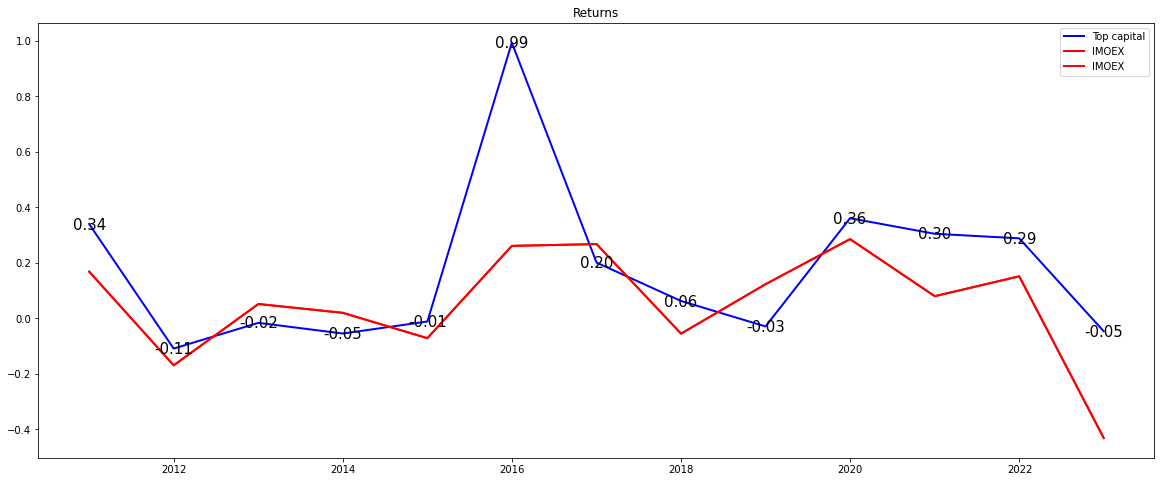

In [43]:
# Create the first plot for returns
fig1, ax1 = plt.subplots(figsize=(20, 8))
ax1.plot(df_weighted.index, df_weighted['return'], linewidth=2.0, color='blue', label='Top capital')
ax1.plot(df_weighted.index, df_weighted['return_imoex'], linewidth=2.0, color='red', label='IMOEX')
for i, y in enumerate(df_weighted['return']):
    ax1.text(df_weighted.index[i], y - 0.03, f'{y:.2f}', ha='center', va='bottom', fontsize=15)
ax1.set_title('Returns')
ax1.legend()
plt.savefig('returns_weighted_2010-2022.jpg', bbox_inches='tight', dpi=100)
plt.show()

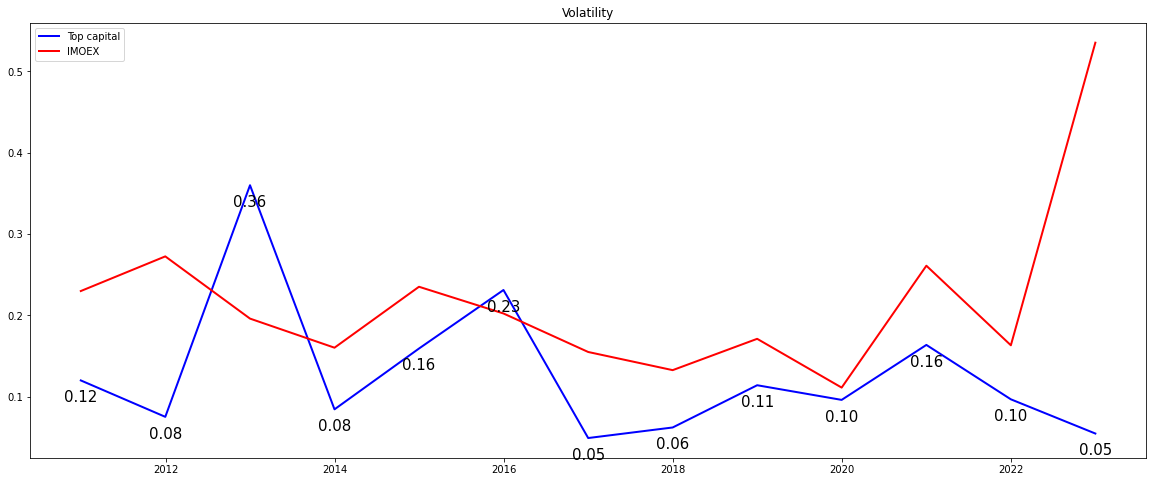

In [30]:
# Create the second plot for volatility
fig2, ax2 = plt.subplots(figsize=(20, 8))
ax2.plot(df_weighted.index, df_weighted['volatility'], linewidth=2.0, color='blue', label='Top capital')
ax2.plot(df_weighted.index, df_weighted['volatility_imoex'], linewidth=2.0, color='red', label='IMOEX')
for i, y in enumerate(df_weighted['volatility']):
    ax2.text(df_weighted.index[i], y - 0.03, f'{y:.2f}', ha='center', va='bottom', fontsize=15)
ax2.set_title('Volatility')
ax2.legend()
plt.savefig('volatility_weighted_2010-2022.jpg', bbox_inches='tight', dpi=100)
plt.show()

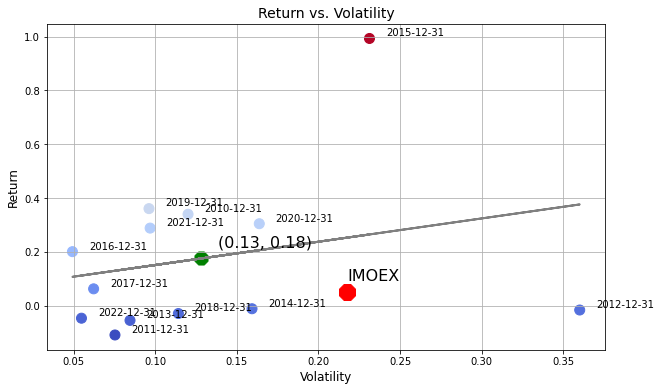

Weighted average return: 0.1756600851984034
Weighted average volatility: 0.1283122989728769


In [31]:
# Create scatter plot with text annotations and trend line
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.scatter(df_weighted['volatility'], df_weighted['return'], s=100, c=df_weighted['return'], cmap='coolwarm')
ax.scatter( df_weighted['volatility'].mean(), df_weighted['return'].mean(), color = 'green',marker = '8', s = 200)
ax.scatter(df_weighted['volatility_imoex'].mean(),df_weighted['return_imoex'].mean(), color = 'red',marker = '8', s = 300)

for i, year_range in enumerate(df_weighted.index.date):
    ax.text(df_weighted['volatility'][i] + 0.01, df_weighted['return'][i] + 0.01, year_range, fontsize=10)
z = np.polyfit(df_weighted['volatility'], df_weighted['return'], 1)
p = np.poly1d(z)
ax.plot(df_weighted['volatility'], p(df_weighted['volatility']), "-", color='gray', linewidth=2)

# Set labels and title
ax.set_xlabel('Volatility', fontsize=12)
ax.set_ylabel('Return', fontsize=12)
ax.set_title('Return vs. Volatility', fontsize=14)

ax.annotate(( df_weighted['volatility'].mean().round(2),df_weighted['return'].mean().round(2)), ( df_weighted['volatility'].mean()+ 0.01, df_weighted['return'].mean()+0.03),
            horizontalalignment='left',
            fontsize=16,
            verticalalignment='bottom')

ax.annotate(('IMOEX'), (df_weighted['volatility_imoex'].mean(), df_weighted['return_imoex'].mean()+0.03),
            horizontalalignment='left',
            fontsize=16,
            verticalalignment='bottom')

# Add colorbar
#fig.colorbar(im, ax=ax)

# Add grid
ax.grid()
plt.savefig('ret vs vol weighted.jpg', bbox_inches='tight', dpi = 100)
plt.show()
print("Weighted average return:", df_weighted['return'].mean())
print("Weighted average volatility:", df_weighted['volatility'].mean())

In [32]:
print("Weighted average return:", df_weighted['return_imoex'].mean())
print("Weighted average volatility:", df_weighted['volatility_imoex'].mean())

Weighted average return: 0.05242911692932396
Weighted average volatility: 0.2174477882908019


### Что очень интересно, так это то, что года распределись поровну снизу и сверху. С чем это может быть связано? Лишь с тем, что стратегия неэффективна

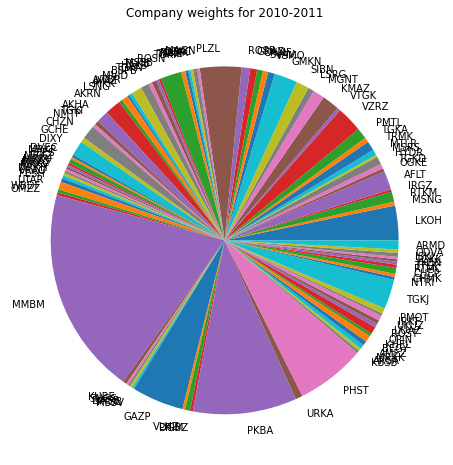

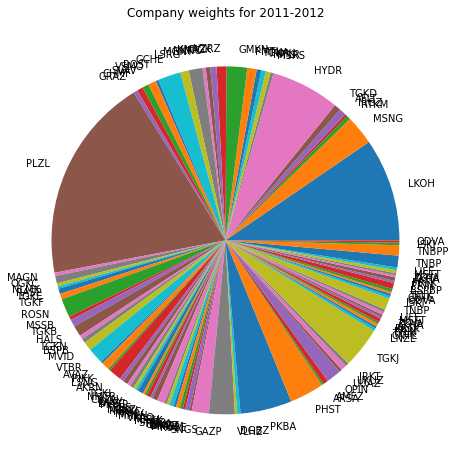

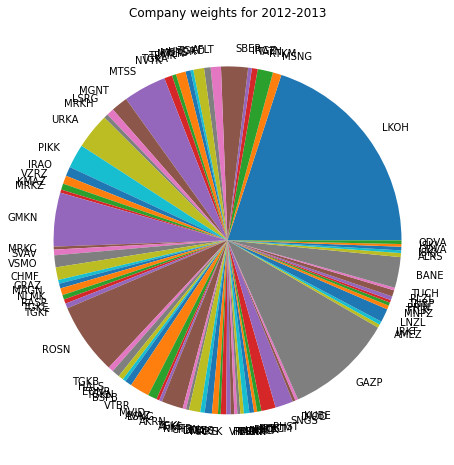

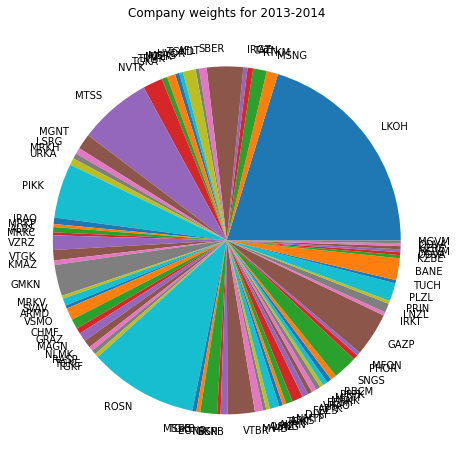

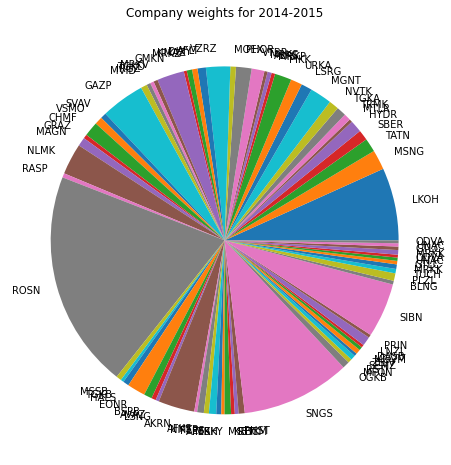

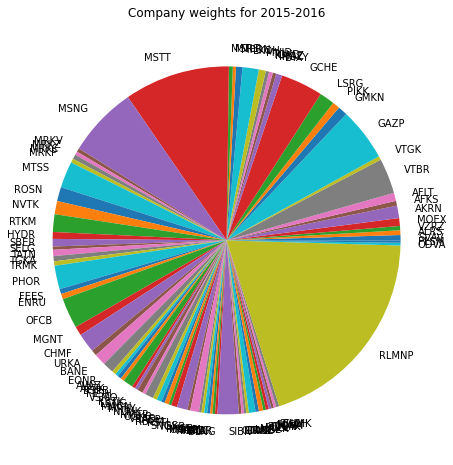

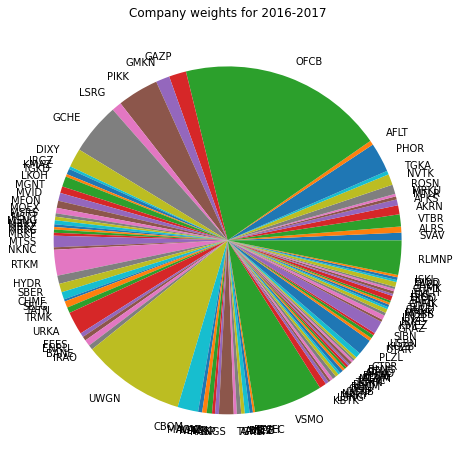

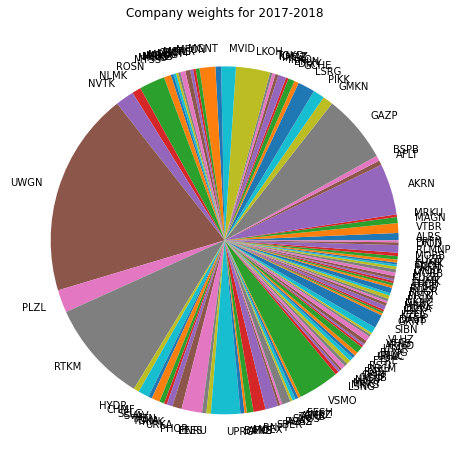

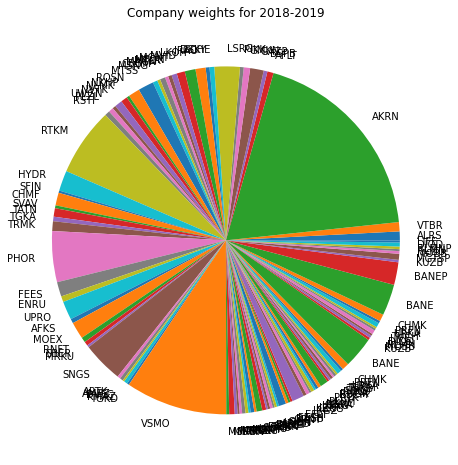

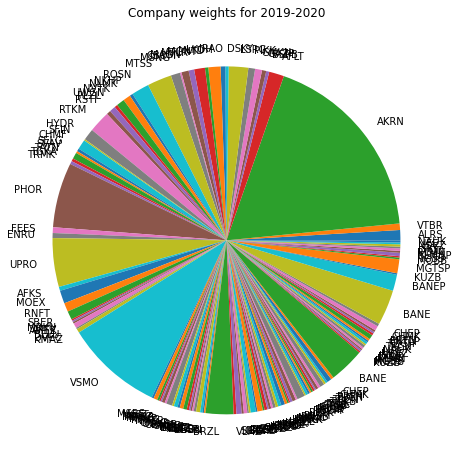

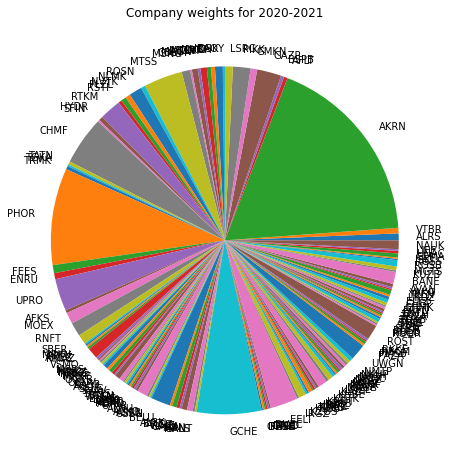

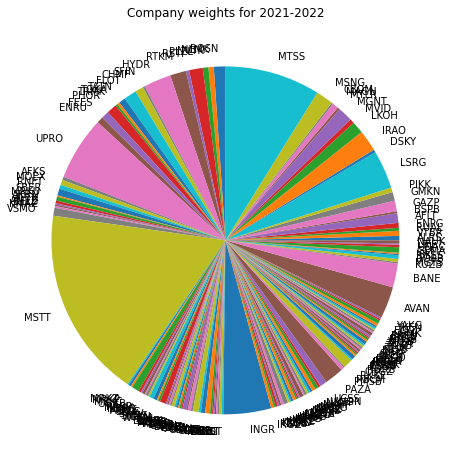

In [18]:
for i in range(1, 13):
    df = globals()[f"information_{i+2009}_{(i+1)+2009}"][1]
    df = df.fillna(0) # fill NaN values with 0
    plt.figure(figsize=(8, 8))
    plt.pie(df.values, labels=df.index)
    plt.title(f'Company weights for {i+2009}-{(i+1)+2009}')
    plt.show()


In [50]:
df_weighted

,return,volatility,return_imoex,volatility_imoex,excess,outperformed
TRADEDATE,,,,,,
2010-12-31,0.339838,0.120111,0.168337,0.229998,0.171501,Yes
2011-12-31,-0.108896,0.075343,-0.169290,0.272591,0.060394,Yes
2012-12-31,-0.016138,0.360079,0.051696,0.196111,-0.067834,No
2013-12-31,-0.054662,0.084563,0.019909,0.160346,-0.074571,No
2014-12-31,-0.011397,0.159305,-0.071452,0.235259,0.060056,Yes
2015-12-31,0.993259,0.231277,0.261168,0.202411,0.732091,Yes
2016-12-31,0.200806,0.049285,0.267611,0.155074,-0.066805,No
2017-12-31,0.062629,0.062262,-0.055081,0.132745,0.117710,Yes
2018-12-31,-0.029158,0.114191,0.123044,0.171257,-0.152202,No
